In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from stable_baselines3 import PPO

/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rootdir = Path().resolve().parent
exptdir = rootdir / "scripts" / "lagfeature_sharpratio" / "out"
cachedir = rootdir / "data" / "cache" / "df"

In [3]:
import sys
sys.path.append(str(rootdir))
import src.utils.data as data
import src.markets.lagfeaturesharpratio as markets

In [4]:
NUM_DIVIDE = 5
MINUTES = "1min"
NUM_TAIN_ENV_STEPS = 288
N_LAG = 15

In [5]:
df, features = data.load_bybit_data(
    num_divide=NUM_DIVIDE,
    interval=MINUTES,
)

['StochasticOscillator_stoch_1',
 'StochRSIIndicator_stoch_rsi_k_1',
 'StochRSIIndicator_stoch_rsi_d_2',
 'DonchianChannel_dcp_2',
 'DonchianChannel_dcw_1',
 'PercentagePriceOscillator_ppo_2',
 'PercentagePriceOscillator_ppo_hist_2',
 'PercentagePriceOscillator_ppo_signal_1',
 'VortexIndicator_vortex_ind_diff_2',
 'StochRSIIndicator_stoch_rsi_k_2',
 'MACD_macd_diff_2',
 'KSTIndicator_kst_2',
 'EaseOfMovementIndicator_em_2',
 'ChaikinMoneyFlowIndicator_cmf_1',
 'ROCIndicator_roc_2',
 'KSTIndicator_kst_diff_2',
 'MFIIndicator_mfi_1',
 'UlcerIndex_ui_1',
 'KSTIndicator_kst_sig_2',
 'CCIIndicator_cci_1',
 'WilliamsRIndicator_wr_2',
 'DPOIndicator_dpo_1',
 'AroonIndicator_aroon_up_1',
 'BollingerBands_bbli_2',
 'MassIndex_mass_index_2',
 'KeltnerChannel_kcp_1',
 'KeltnerChannel_kcw_2',
 'PercentagePriceOscillator_ppo_hist_1',
 'MFIIndicator_mfi_2',
 'PercentageVolumeOscillator_pvo_2',
 'UlcerIndex_ui_2',
 'ROCIndicator_roc_1',
 'BollingerBands_bbp_2',
 'KeltnerChannel_kchi_1',
 'AwesomeOsci

In [34]:
fold = 1

df_train1, df_train2 = (
    df.loc[df["fold"] < (fold - 1)].reset_index(drop=True),
    df.loc[df["fold"] > (fold - 1)].reset_index(drop=True),
)
df_eval = df.loc[df["fold"] == (fold - 1)].reset_index(drop=True)

In [39]:
train_env = markets.DualMarketEnv(
    df1=df_train1,
    df2=df_train2,
    features=features,
    num_steps=NUM_TAIN_ENV_STEPS,
    n_lag=N_LAG,
    market_cls=markets.Market,
    is_single_transaction=False,
)
eval_env = markets.MarketEnv(
    df=df_eval,
    features=features,
    num_steps=NUM_TAIN_ENV_STEPS,
    n_lag=N_LAG,
    market_cls=markets.Market,
    is_single_transaction=False,
)

In [37]:
model = PPO.load(str(exptdir / f"fold{fold}" / "best_model"))

In [40]:
train_env.reset()
market_env = train_env.env_to_use

eval_env.reset()
market_env = eval_env

obs = market_env.reset()
log = []
for i in range(market_env.market.num_steps):
    action_idx, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = market_env.step(action_idx)
    log.append([action_idx, reward, done] + obs["state_0"][:3].tolist())
log = pd.DataFrame(log, columns=["action", "reward", "done", "fb", "fs", "rtn"])

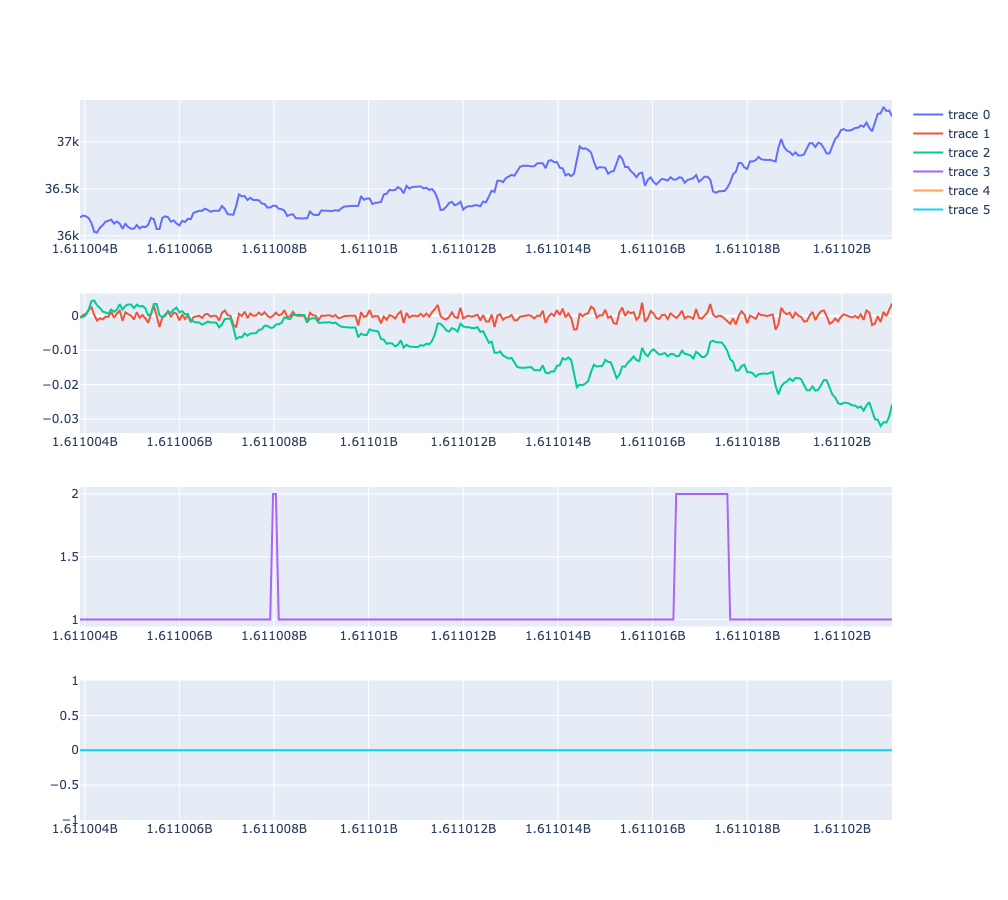

In [41]:
dfm = market_env.market.raw_df.iloc[N_LAG:-1].reset_index(drop=True)
dfm = pd.concat([dfm, log], axis=1).iloc[:-1]

buyprice, sellprice = None, None
rtns = []
for price, action in dfm[["close", "action"]].values:
    if buyprice is None and action == 0:
        buyprice = price
    elif sellprice is None and action == 1:
        sellprice = price
    
    if buyprice is not None and sellprice is not None:
        rtns.append(sellprice / buyprice - 1)
        buyprice, sellprice = None, None
    else:
        rtns.append(0)

x = dfm["timestamp"].values

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(
    x=x,
    y=dfm["close"].values
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=dfm["reward"].values
), row=2, col=1)
fig.add_trace(go.Scatter(
    x=x,
    y=dfm["reward"].cumsum().values
), row=2, col=1)
fig.add_trace(go.Scatter(
    x=x,
    y=dfm["action"].values
), row=3, col=1)

        
fig.add_trace(go.Scatter(
    x=x,
    y=rtns,
), row=4, col=1)
fig.add_trace(go.Scatter(
    x=dfm["timestamp"].values,
    y=np.cumsum(rtns),
), row=4, col=1)


fig.update_layout(height=900, width=1200)
fig.show()

In [24]:
dfm

,timestamp,close,high,low,volume,action,reward,done,fb,fs,rtn
